## Strategy

> To trade the VIX 

### *Signals*

> Touch of lower bound = close sell and build long position

> Cross of upper std dev multiple = sell entire position


In [52]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime

In [285]:
# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df.head()

# identifying the VIX
vix = df['Series 28'].iloc[0:1120]

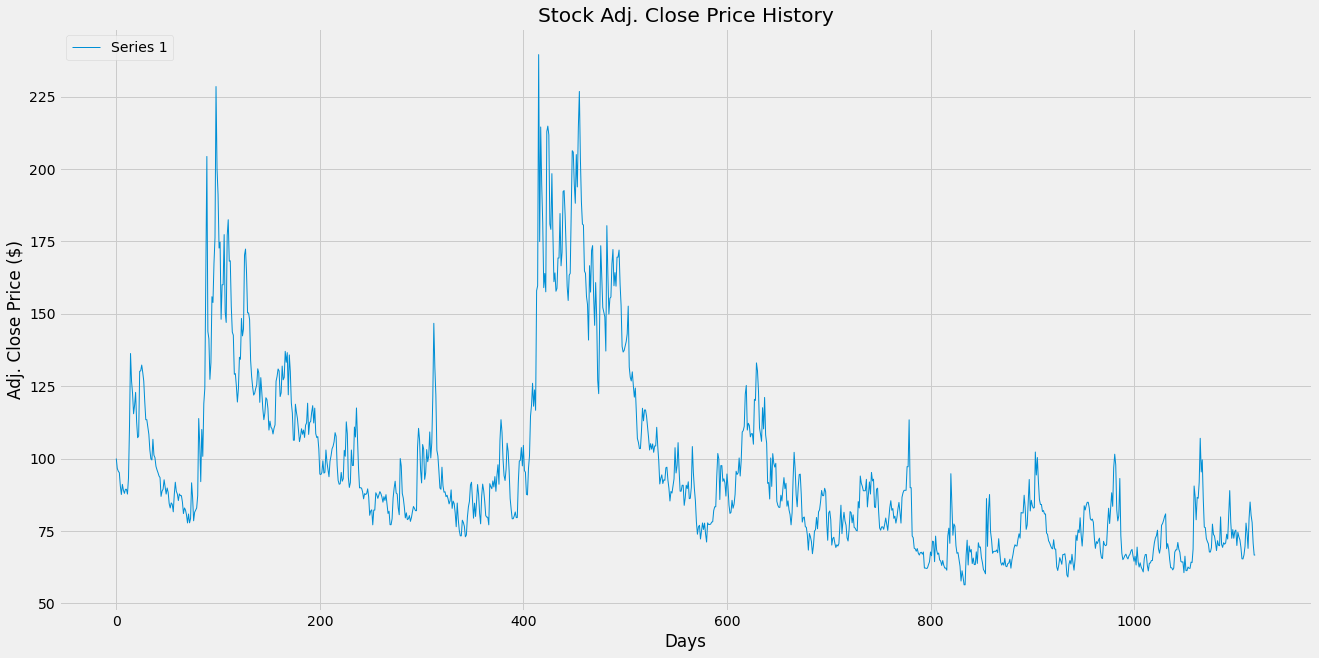

In [286]:
#Visualise the data
plt.figure(figsize=(20, 10))
plt.plot(vix, linewidth = 1)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()

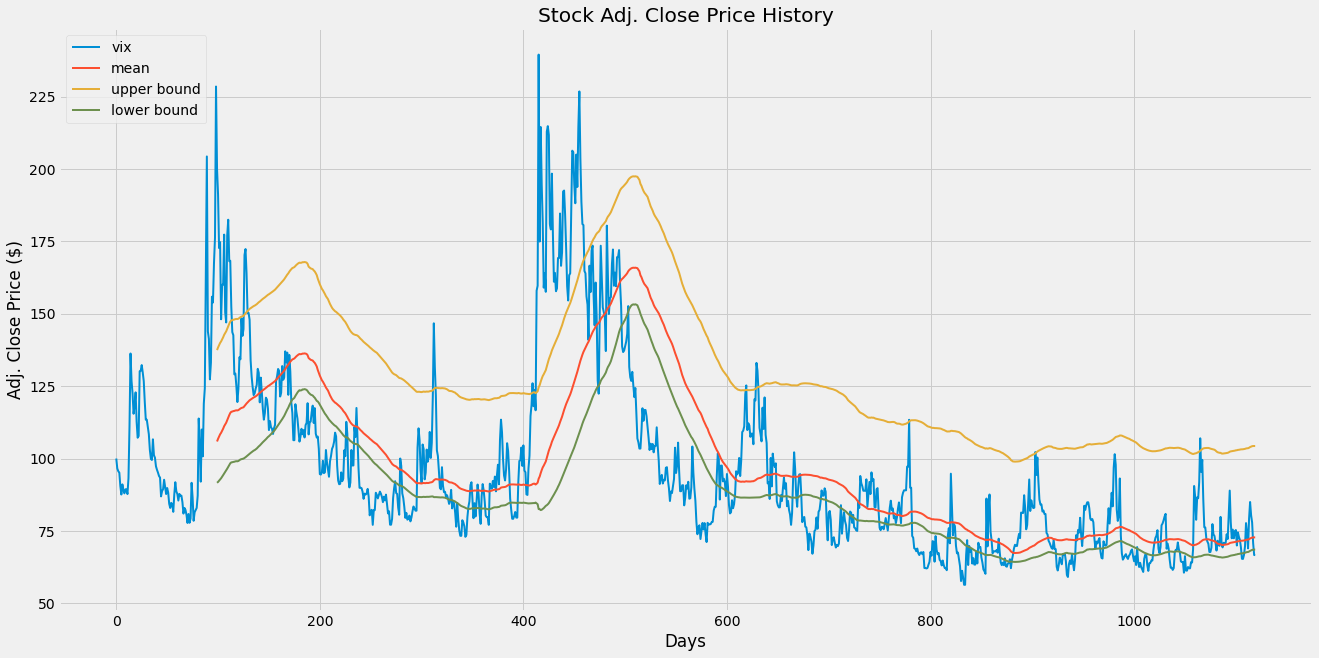

In [287]:
#Visualise the moving average and upper and lower bounds

# inputs
window_mean = 200
window_std = 100
upper_bound = 1    # number of stdv from mean
lower_bound = 0.5     # number of stdv below mean

# plotting
plt.figure(figsize=(20, 10))
plt.plot(vix, linewidth=2, label='vix')
plt.plot(vix.rolling(window=window).mean(), linewidth=2, label='mean')
plt.plot(vix.rolling(window=window).mean() + upper_bound*vix.std()\
         , linewidth=2, label='upper bound')
plt.plot(vix.rolling(window=window).mean() - lower_bound*vix.rolling(window=window_std).std()\
         , linewidth=2, label='lower bound')
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(loc='upper left')
plt.show()

In [288]:
# vix strategy

def vixen(data, window_mean, window_std, upper_bound, lower_bound): 
    # generating simple moving average
    
    # data - is the series to generate signals for
    # window - is the window used to generate the average
    # lag - is how far % past the average before a signal is generated
    
    SMA = data.rolling(window = window).mean()
    upper_bounds = SMA + upper_bound*vix.std()
    lower_bounds = SMA - lower_bound*vix.rolling(window=window_std).std()
    
    # generating signals
    sigPriceBuy = []
    sigPriceSell = []
      
    #flag = 1: long position, flag = 0: short position, flag = -1: no position
    flag = 0

    for i in range(len(data)):
        # closing trade at end of session
        if i == len(data)-1:
            if flag == 1:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data.iloc[i])
                flag = 0
            else: 
                sigPriceBuy.append(data.iloc[i])
                sigPriceSell.append(np.nan)
                flag = 0
        # Touch of lower bound = close sell and build long position
        elif data.iloc[i] < lower_bounds.iloc[i]:
            if flag != 1:
                sigPriceBuy.append(data.iloc[i])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif data.iloc[i] > upper_bounds.iloc[i]:
            if flag != 0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data.iloc[i])
                flag = 0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else: 
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)

    return (sigPriceBuy, sigPriceSell)

buy_sell_data = vixen(vix, window_mean, window_std, upper_bound, lower_bound)
    

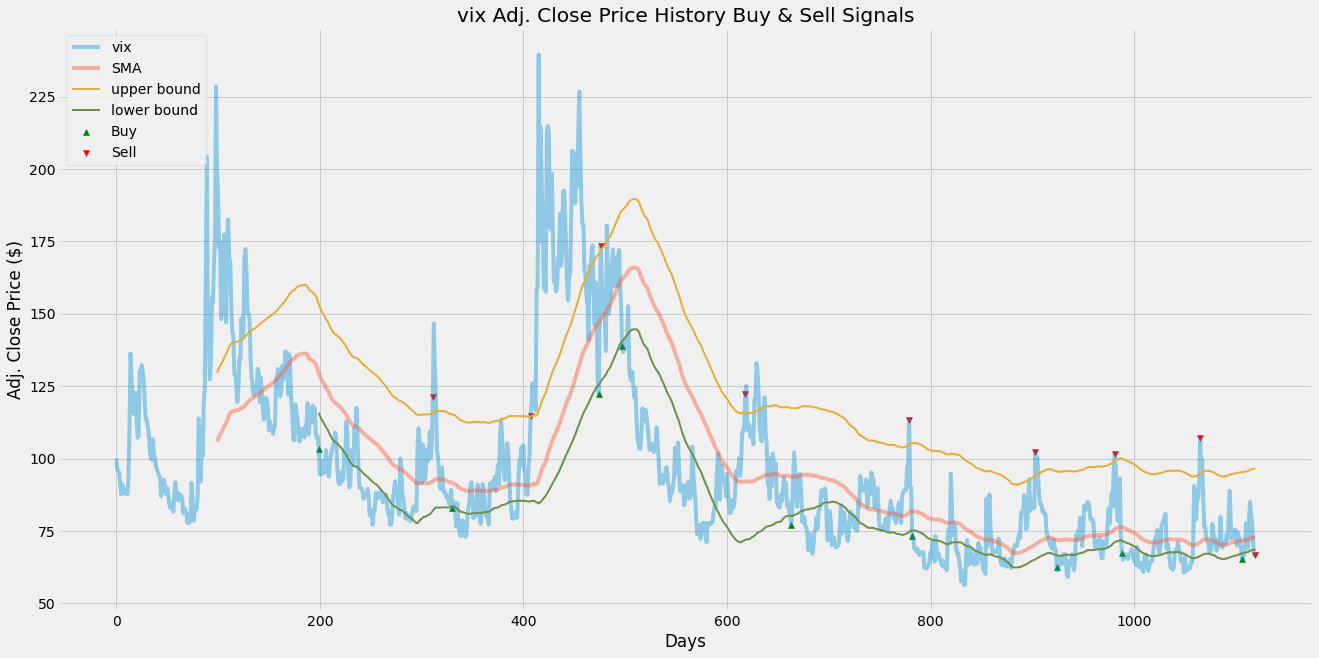

In [289]:
# testing basic strategy
# To test, change window and the series used

# =========================================
# variables
window_mean = 20
window_std = 200
upper_bound = 0.75   # number of stdv from mean
lower_bound = 0.5     # number of stdv below mean
# =========================================

#Store the buy and sell data into a variable
buy_sell_data = vixen(vix, window_mean, window_std, upper_bound, lower_bound)

# visualise test
plt.figure(figsize=(20, 10))
# adding price data
plt.plot(vix, label='vix', alpha=0.4)
plt.plot(vix.rolling(window=window).mean(), label='SMA', alpha=0.4)
plt.plot(vix.rolling(window=window).mean() + upper_bound*vix.std()\
         , linewidth=2, label='upper bound')
plt.plot(vix.rolling(window=window).mean() - lower_bound*vix.rolling(window=window_std).std()\
         , linewidth=2, label='lower bound')
# adding indicators
plt.scatter(vix.index, buy_sell_data[0], label='Buy', marker='^', color='green')
plt.scatter(vix.index, buy_sell_data[1], label='Sell', marker='v', color='red')
plt.title('vix Adj. Close Price History Buy & Sell Signals')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(loc='upper left')
plt.show()

In [290]:
#Calculating returns

def Backtest(data, buy_sell):
    
    profit = np.nansum(buy_sell[1][200:]) - np.nansum(buy_sell[0][200:])
    data_profit = data.iloc[-1] - data.iloc[200]
    
    return profit, data_profit

Backtest(vix, buy_sell_data)

(333.03393213572826, -27.9441117764471)

In [263]:
# optimising parameters

def Optimiser(data):
    
    
    max = [0]
    
    for wm in np.linspace(20,200,9):
        for ws in np.linspace(200,200,1):
            for ub in np.linspace(0.25,3,11):
                for lb in np.linspace(0.1,1,10):
                
                    # profit for tested parameters
                    profit = Backtest(data, vixen(data, int(wm), int(ws), ub, lb))[0]
                    
                    print(profit, wm, ws, ub, lb)
                    
                    if profit > max[0]:
                        max = [profit, wm, ws, ub, lb]
                    
    return max
                  
Optimiser(vix)
    

811.9261477045898 20.0 200.0 0.25 0.1
780.1397205588823 20.0 200.0 0.25 0.2
732.2854291417166 20.0 200.0 0.25 0.30000000000000004
734.8802395209582 20.0 200.0 0.25 0.4
774.3013972055887 20.0 200.0 0.25 0.5
678.0938123752494 20.0 200.0 0.25 0.6
694.0119760479047 20.0 200.0 0.25 0.7000000000000001
559.0818363273452 20.0 200.0 0.25 0.8
503.39321357285417 20.0 200.0 0.25 0.9
368.56287425149685 20.0 200.0 0.25 1.0
769.8602794411177 20.0 200.0 0.525 0.1
755.0399201596806 20.0 200.0 0.525 0.2
784.0319361277443 20.0 200.0 0.525 0.30000000000000004
791.7664670658683 20.0 200.0 0.525 0.4
814.8702594810384 20.0 200.0 0.525 0.5
694.8103792415172 20.0 200.0 0.525 0.6
728.243512974052 20.0 200.0 0.525 0.7000000000000001
634.7804391217564 20.0 200.0 0.525 0.8
601.8463073852292 20.0 200.0 0.525 0.9
479.8403193612771 20.0 200.0 0.525 1.0
702.1457085828342 20.0 200.0 0.8 0.1
698.7524950099798 20.0 200.0 0.8 0.2
731.1876247504988 20.0 200.0 0.8 0.30000000000000004
733.1836327345309 20.0 200.0 0.8 0.4
773

425.3992015968064 42.5 200.0 2.1750000000000003 0.8
425.44910179640715 42.5 200.0 2.1750000000000003 0.9
344.6107784431137 42.5 200.0 2.1750000000000003 1.0
427.195608782435 42.5 200.0 2.45 0.1
435.8283433133732 42.5 200.0 2.45 0.2
437.77445109780433 42.5 200.0 2.45 0.30000000000000004


KeyboardInterrupt: 

In [ ]:

max = ['']
max[0]